# Normal DCGAN

In [1]:
import os
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision.utils import save_image
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
%matplotlib inline
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

# Enable GPU
cuda = True if torch.cuda.is_available() else False

Parameters

In [3]:
# General

epochs = 50
batch_size = 64
n_cpu = 1
samples = 500
seed = 1
sample_interval = 5000
checkpoint_interval = 10
print_interval = 391

# Hyperparameters: Adam optimizer parameters (learning rate and momentum decay)

lr = 0.0002
b1 = 0.5
b2 = 0.999

# Dimensions of latent space

latent_dim = 100

Configuring dataset and checking images

In [4]:
# Configure data loader and image parameters

img_dim = 32
img_channels = 3

os.makedirs('./data/cifar10', exist_ok=True)

transform=transforms.Compose([
    transforms.Resize(img_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True,
                       transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


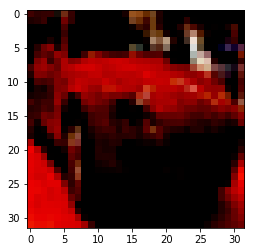

In [5]:
i, _ = dataset[5]
show(i)

Setting seed

In [6]:
# CPU
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# GPU
if torch.cuda.is_available():
        print("Using cuda.")
        torch.cuda.manual_seed_all(seed)

Using cuda.


Generator: since nn.Upsample is deprecated in favour of nn.functional.interpolate I have made a custom nn.Module class to include this in the nn.Sequential.

In [7]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_dim // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128*self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            Interpolate(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            Interpolate(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [   nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_dim // 2**4
        self.adv_layer = nn.Sequential( nn.Linear(128*ds_size**2, 1),
                                        nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

Function to initialise weights

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Initialising and configuring metrics

In [10]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print(generator)
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Interpolate()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Interpolate()
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): Conv2d(16, 32, kerne

Training

In [11]:
gen_loss = []
disc_loss = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Tensor(imgs.shape[0], 1).fill_(1.0)
        fake = Tensor(imgs.shape[0], 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(Tensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        gen_loss.append(g_loss)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        disc_loss.append(d_loss)

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], 'images/%d.png' % batches_done, nrow=5, normalize=True)
        if (batches_done + 1) % print_interval == 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, i, len(dataloader),
                                                                d_loss.item(), g_loss.item()))
            
            
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), 'saved_models/generator_%d.pth' % epoch)
        torch.save(discriminator.state_dict(), 'saved_models/discriminator_%d.pth' % epoch)



[Epoch 0/50] [Batch 390/782] [D loss: 0.690119] [G loss: 0.685009]
[Epoch 0/50] [Batch 781/782] [D loss: 0.691298] [G loss: 0.714511]
[Epoch 1/50] [Batch 390/782] [D loss: 0.685620] [G loss: 0.709720]
[Epoch 1/50] [Batch 781/782] [D loss: 0.694044] [G loss: 0.708949]
[Epoch 2/50] [Batch 390/782] [D loss: 0.693050] [G loss: 0.689081]
[Epoch 2/50] [Batch 781/782] [D loss: 0.690652] [G loss: 0.696676]
[Epoch 3/50] [Batch 390/782] [D loss: 0.694324] [G loss: 0.691677]
[Epoch 3/50] [Batch 781/782] [D loss: 0.688619] [G loss: 0.699967]
[Epoch 4/50] [Batch 390/782] [D loss: 0.693947] [G loss: 0.698206]
[Epoch 4/50] [Batch 781/782] [D loss: 0.694621] [G loss: 0.700401]
[Epoch 5/50] [Batch 390/782] [D loss: 0.693297] [G loss: 0.689382]
[Epoch 5/50] [Batch 781/782] [D loss: 0.697443] [G loss: 0.678003]
[Epoch 6/50] [Batch 390/782] [D loss: 0.694985] [G loss: 0.694275]
[Epoch 6/50] [Batch 781/782] [D loss: 0.694370] [G loss: 0.697986]
[Epoch 7/50] [Batch 390/782] [D loss: 0.724758] [G loss: 0.632

In [12]:
# Save latest and print latest
torch.save(generator.state_dict(), 'saved_models/generator_50.pth')
torch.save(discriminator.state_dict(), 'saved_models/discriminator_50.pth')
save_image(gen_imgs.data[:25], 'images/%d.png' % batches_done, nrow=5, normalize=True)

In [13]:
plot_d = [float(x) for x in disc_loss]
plot_g = [float(x) for x in gen_loss]

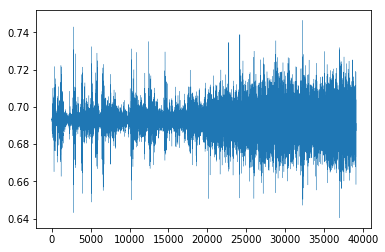

In [14]:
plt.plot(plot_d,linewidth=0.3)

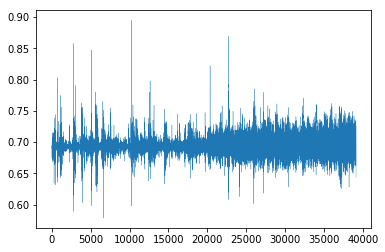

In [16]:
plt.plot(plot_g,linewidth=0.3)

It seems the sampled images are increasing in complexity, however there is no sign of the generator loss decreasing... Loss oscillations decrease towards the final iterations.